# Statistical Analysis of Adoptable Animals Data


* The EDA brought about a few interesting questions that we can hypothesize about.


* While testing the validity and statistical significance of the hypotheses, we may come up with more interesting questions.


* The quetions/hypotheses drawn from the EDA done in the previous notebook are:
    * Notes: Adoptability will be calculated as the percent of Adoptions in All other shelter outcomes.
    * Notes: I will employ hacker statistics for all testing as it is widely applicable and I have enough computing power to produce viable results.
    
    
    1. Does age play an important role in the adoptability/time to adoption of the dogs?
        * The ages of interest are puppies/non puppies.
        * I will test the hypothesis that puppies get adopted more often and quicker than older dogs.
        
     
    2. Does having a secondary color make dogs more adoptable and decrease the time to adoption?
        * I will test the hypothesis that dogs that have secondary colors are more adoptable and will get adopted sooner than dogs without secondary colors.
        
        
    3. Is there a difference in adoptability/time to adoption for males as compared to females?
        * I hypothesize that there isn't a difference.
        
        
    4. Does the population of a breed in the shelter play an important role in adoptability/time to adoption?
        * So sample size isn't too uneven, I will test the top 5 breeds that enter the shelter versus all the others.
        
        
    5. Does the primary breed American Kennel Club group play an influential role in adoptability/time to adoption?
        * There are 8 AKC breed groupings.
        * Does any one grouping stand out from the rest in terms of adoptability/time to adoption?
        * I hypothesize that one will and breed grouping is an important factor.
        
        
    6. Is there a correlation between time to adoption and intake age?
        * I hypothesize that there is a correlation.
        
        
    7. Are adoptions affected by seasons?
        * I hypothesize that adoptions occur more often in the spring and fall than in summer or winter.
        
*****

### First step is to load the data needed.
* Also, the data will be wrangled a bit more to change the outcome type column to reflect the 3 major groupings identified in the previous notebook for EDA.  The groups are: 
    * Adoptions
    * Transfers
    * Deaths

In [1]:
#load the necessary datasets and packages
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats

dogs_join = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join.csv", 
                        parse_dates=True, encoding='latin-1')
dogs_adoptions = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_adoptions.csv", 
                        parse_dates=True, encoding='latin-1')
dogs_transfers = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_transfers.csv", 
                        parse_dates=True, encoding='latin-1')
dogs_deaths = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_deaths.csv", 
                        parse_dates=True, encoding='latin-1')
return_visits = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/return_visits.csv", 
                        parse_dates=True, encoding='latin-1')
with open("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dog_ages.json") as file:
    dog_ages = json.load(file) 
with open("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/seasons.json") as file:
    seasons = json.load(file)
    
#create a column in the dogs_join dataframe that changes the outcome_type to the three categories 
#above (adoptions, transfers, deaths)
for index, row in dogs_join.iterrows():
    if row['outcome_type'] in dogs_adoptions.outcome_type.unique():
        dogs_join.loc[index, 'outcome_type'] = 'Adoption'
    elif row['outcome_type'] in dogs_transfers.outcome_type.unique():
        dogs_join.loc[index, 'outcome_type'] = 'Transfer'
    else:
        dogs_join.loc[index, 'outcome_type'] = 'Death'

C:\Users\sethh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#check to see if the loop worked.
dogs_join.outcome_type.unique()

array(['Adoption', 'Transfer', 'Death'], dtype=object)

#### Set up the test statistics and functions to calculate them.
* For adoptability, I will calculate the difference in the fraction of category of interest adopted and the non category adopted from the sample population.
* Time to adoption will be assessed via the difference of expected values (standard deviation) of time to adoption distributions of category vs. non category.
    *  This is because time to adoption is roughly exponentially distributed as shown earlier and this is more accurate as to the time to adoption summary stat for groups in the shelter.

In [3]:
#we need to break the data up into category and non category for each category
#define a function to generate the groupings dataframes
def group_dfs(df, col, category):
    """
    Groups the dataframes into the correct groupings based off of a identifier from a dataframe column
    """
    cat = df.loc[df[col] ==category]
    non_cat = df.loc[df[col] !=category]
    return(cat, non_cat)
    
#also now define the function to calculate the difference in adoption percentages
def diff_adopt_per(data1, data2, data1_adopt, data2_adopt):
    """
    Takes dataframes or series or arrays 1 and 2 and the adoptions from those dataframes or series
    or arrays and returns the difference in adoption percentages from the
    two dataframes/categories.
    """
    adopt1 = len(data1_adopt)/len(data1)
    adopt2 = len(data2_adopt)/len(data2)
    diff_adopt = adopt2 - adopt1
    return(diff_adopt, adopt1, adopt2)

#and define a function to calculate the difference of 3rd quantiles
def diff_std_dev(data1, data2):
    return(np.std(data2) - np.std(data1))

* Now we need to make a function to run the statistical test for difference in time to adoptions and adoptability.
    * For both tests, the null hypothesis is that there is not a difference, and the test will be set up under this assumption.
        * The assumption being that the the distribution of adoptions between the two groups are not different.
    * I will use permutation replicates to generate samples to create a distribution of differences for both adoptability and standard deviations of time to adoptions.
    * The p-value of the test will be calculated by taking the number of permutation replicates that have a difference as extreme or more extreme than the empirical difference divided by the total number of permutation replicates generated.


* The test setup for difference in adoptability:
    * The test statistic is going to be the difference of the adoption ratios between the two groups.
    * The first step is to calculate the empirical ratio values and differences between those values.
    * Then, model the data to represent the null hypothesis, which is that there isn't a difference in adoption distributions between the two groups.
        * This is done by concatenating the two groups and taking a permutation of the data as a whole.
        * Then, assign the permuted results out to each group according to the number of entries contributed to the concatenated array by that group.
            * For instance, puppy vs. non-puppy, the first ~23,000 would be put into the permuted puppy array, and the rest into the permuted non-puppy array.
    * Next, calculate the test statistic which is the permuted ratios and difference of those ratios.  
    * Repeat this many times to generate a distribution of differences in permuted ratios.
    * The p-value is finally calculated by taking the number of permuation replicates (difference in permuted ratios) that are as least as extreme as the empirical difference in ratios.
    
    
* The test setup for difference in time to adoption:
    * The test statistic is going to be the difference in standard deviation of the time to adoption for the different categories.  The standard deviation is the expected value of an exponential distributions, which the time to adoption closely resembles.  
    * Calculate the empirical difference of standard devations of time to adoption values.
    * Then, model the data to represent the null hypothesis, which is that there isn't a difference in time to adoption distributions between the two groups.
        * Done by concatenating the two groups and taking a permutation of the data as a whole.
        * Then, assign the permuted results out to each group according to the number of entries contributed to the concatenated array by that group.
    * Next, calculate the test statistic, which is the difference of standard deviations of the permuted samples.
    * Repeat this many times to generate a distribution of differences in standard deviations.
    * The p-value is finally calculated by taking the number of permuation replicates (difference in permuted standard deviations) that are as least as extreme as the empirical difference in standard deviations.

In [4]:
#define the functions to run the statistical test for difference in adoptability
def perm_rep_draw(calc,data1,data2,func,size):
    """Generates permutation replicates of desired size and function."""
    
    # Initialize permutation replicates: perm_replicates
    perm_replicates = np.empty(size)
    
    #set lengths of categories
    cat_length = len(data1)
    
    #concatenate the two data groups
    concat_data = data1.append(data2).reset_index(drop=True)
    concat_index = concat_data.index.values
    
    # Draw perm_replicates
    for i in range(size):
        # Permute index and split into sets
        permuted_index = np.random.permutation(concat_index)
        permuted_cat_index = permuted_index[:cat_length]
        permuted_non_cat_index = permuted_index[cat_length:]
        
        # Now assign the permuted data based on the permuted index
        permuted_cat = concat_data[permuted_cat_index]
        permuted_non_cat = concat_data[permuted_non_cat_index]

        # Compute replicate with function from data low and high
        if calc == 'ratio':
            perm_replicates[i],j,k  = func(permuted_cat, permuted_non_cat, permuted_cat[permuted_cat=='Adoption'],permuted_non_cat[permuted_non_cat=='Adoption'])
        else:
            perm_replicates[i] = func(permuted_cat, permuted_non_cat)
    return perm_replicates

def adopt_diff_test(col, category, num_reps):
    """
    Executes the adoption ratio statistical test on the column and category(grouping) of choice by generating num_reps number
    of replicates.
    """
    #set up test parameters
    cat, non_cat = group_dfs(dogs_join, col, category)
    cat_adopt, non_cat_adopt = group_dfs(dogs_join.loc[dogs_join.outcome_type=='Adoption'], col, category)
    
    
    print((category + " group data points: {}. Non-" + category + " group data points: {}.")
          .format(len(cat), len(non_cat)))

    #empirical difference of ratios
    emp_diff_ratio, emp_cat, emp_non = diff_adopt_per(cat, non_cat, cat_adopt, non_cat_adopt)
    print('The empirical '+category+(' ratio:{}').format(emp_cat))
    print(('The empirical non-'+category+' ratio:{}').format(emp_non))
    print('The empirical difference of ratios(non minus cat) is {}.'.format(emp_diff_ratio))
    print('')
        
    #generate the replicates
    perm_replicates = perm_rep_draw('ratio', cat['outcome_type'], non_cat['outcome_type'], diff_adopt_per, num_reps)
        
    # Compute p-value: p
    if emp_diff_ratio > 0:
        p = np.sum(perm_replicates >= emp_diff_ratio)/len(perm_replicates)
    else:
        p = np.sum(perm_replicates <= emp_diff_ratio)/len(perm_replicates)
    print("The 95% confidence interval is {} to {}.".format(np.percentile(perm_replicates,2.5),np.percentile(perm_replicates,97.5)))
    print('p-val =', p)

    #make a histogram of the replicate correlations and show where the empirical result lies
    plt.figure(figsize=(12,6))
    pd.Series(perm_replicates).hist(alpha=0.3, normed=True, bins=50)
    plt.plot([emp_diff_ratio,emp_diff_ratio], [0,80])
    plt.title('Difference in Means of Ratios between ' + category + ' and non-' + category)
    plt.ylabel('PDF')
    plt.xlabel('Difference of Ratios non-'+category+' minus '+category)
    plt.legend(['Empirical Difference','Difference Replicates'], loc='upper left')
    plt.show()
    
    
def time_diff_test(col, category, num_reps):
    #set up test parameters
    cat_adopt, non_cat_adopt = group_dfs(dogs_join.loc[dogs_join.outcome_type=='Adoption'], col, category)
    
    
    print((category + " group data points: {}. Non-" + category + " group data points: {}.")
          .format(len(cat_adopt), len(non_cat_adopt)))

    #empirical difference of standard deviations
    emp_diff_std = diff_std_dev(cat_adopt.shelter_time, non_cat_adopt.shelter_time)
    print((category + ' std:{}').format(np.std(cat_adopt.shelter_time)))
    print(('Non-'+category+' std:{}').format(np.std(non_cat_adopt.shelter_time)))
    print('The empirical difference of time to adoption expected value or standard deviation(non minus cat) is {}.'.format(emp_diff_std))
    print('')
        
    #generate the replicates
    perm_replicates = perm_rep_draw('std', cat_adopt['shelter_time'], non_cat_adopt['shelter_time'], diff_std_dev, num_reps)
        
    # Compute p-value: p
    if emp_diff_std > 0:
        p = np.sum(perm_replicates >= emp_diff_std)/len(perm_replicates)
    else:
        p = np.sum(perm_replicates <= emp_diff_std)/len(perm_replicates)
    print("The 95% confidence interval is {} to {}.".format(np.percentile(perm_replicates,2.5),np.percentile(perm_replicates,97.5)))
    print('p-val =', p)

    #make a histogram of the replicate correlations and show where the empirical result lies
    plt.figure(figsize=(12,6))
    pd.Series(perm_replicates).hist(alpha=0.3, normed=True, bins=50)
    plt.plot([emp_diff_std,emp_diff_std], [0,.3])
    plt.title('Difference in Standard Deviation between ' + category + ' and non-' + category)
    plt.ylabel('PDF')
    plt.xlabel('Difference of standard deviation non-'+category+' minus '+category)
    plt.legend(['Empirical Difference','Difference Replicates'], loc='upper left')
    plt.show()

## 1. Does age play an important role in the adoptability/time to adoption of the dogs?
* I hypothesize that there is a difference between puppies' and non-puppies' adoptability and time to adoptions.
* Puppies are defined as being less than or equal to 1 year old, and all other ages or defined as non-puppies.
* The test significance level is $\alpha$ = 0.05.
* The null hypothesis is that there is not a difference in distributions of adoptions or time to adoption.

Puppy group data points: 24160. Non-Puppy group data points: 25404.
The empirical Puppy ratio:0.7308774834437086
The empirical non-Puppy ratio:0.7555109431585577
The empirical difference of ratios(non minus cat) is 0.024633459714849093.

The 95% confidence interval is -0.007587628949292102 to 0.007594237388699243.
p-val = 0.0


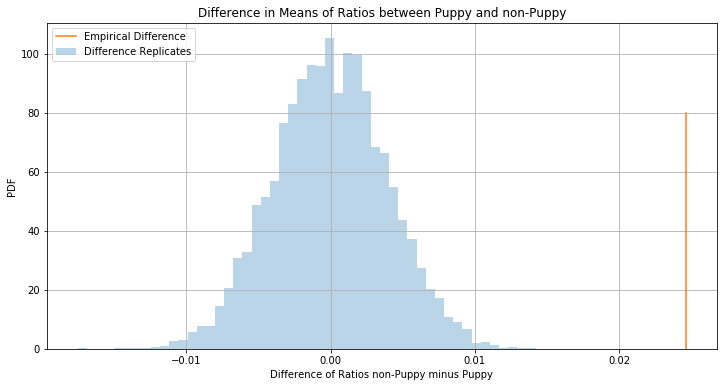

Puppy group data points: 17658. Non-Puppy group data points: 19193.
Puppy std:29.29206977073028
Non-Puppy std:57.562843951360264
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 28.270774180629985.

The 95% confidence interval is -6.196931703241638 to 5.980085125517942.
p-val = 0.0


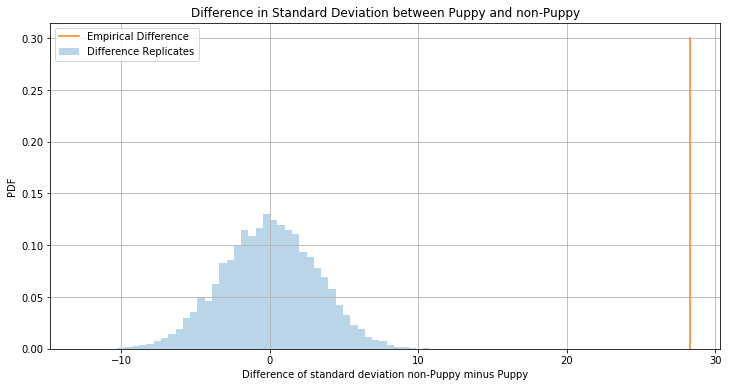

In [5]:
#set the random seed and run the test
np.random.seed(42)

#adoption ratio test
adopt_diff_test('intake_age_cat', 'Puppy', 10000)

#time to adoption test
time_diff_test('intake_age_cat', 'Puppy', 10000)

### Results (Puppy vs. Non-Puppy)
* The test shows that in 10000 iterations, there was not one case found where the difference in adoption ratios was as extreme as the empirical difference in adoption ratios.
* So, we can reject the null hypothesis that there is not a difference in adoption ratios between puppies and non puppies.  The p-value is below $\alpha$. 
* Moreover, the empirical difference in ratios suggests that Non-Puppies (anything not classified in the age range of a puppy) are adopted more than puppies.


* For the time to adoption tests, it seems that the null hypothesis can be rejected as well ,and there is a statistical result that the distributions of time to adoptions aren't the same.
    * It seems that the time to adoption may indeed take longer for non-puppies based on the result above. 


** The result above suggests that more time and attention should be spent on trying to get older dogs adopted sooner.  Puppies don't seem to have a very hard time getting adopted as compared to the older dogs.**
    
*****

## 2. Does Solid vs. Mixed Coat coloration have an effect on adoptions and time to adoption?
* I hypothesize that there is a difference between solid and mixed coat color adoptions and time to adoption.
* Solids are defined as having a secondary color value of 'None', and all other dogs have mixed coat color.
* The test significance level is $\alpha$ = 0.05.
* The null hypothesis is that there is not a difference in distributions of adoptions or time to adoption

None group data points: 17069. Non-None group data points: 32495.
The empirical None ratio:0.7270490362645732
The empirical non-None ratio:0.752146484074473
The empirical difference of ratios(non minus cat) is 0.025097447809899864.

The 95% confidence interval is -0.008055002914367893 to 0.008029744067756694.
p-val = 0.0


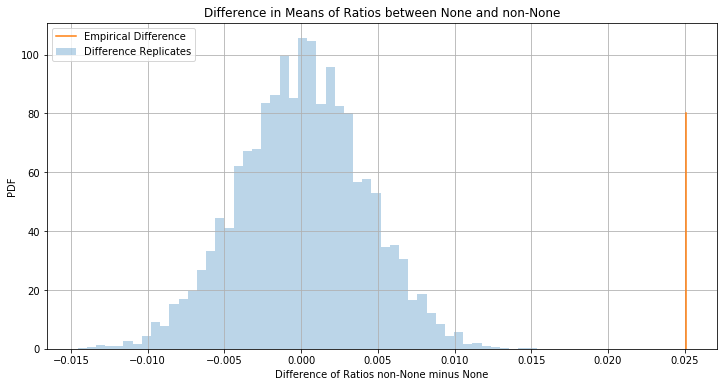

None group data points: 12410. Non-None group data points: 24441.
None std:44.78591662453234
Non-None std:47.03538227865715
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 2.249465654124812.

The 95% confidence interval is -6.694065892949446 to 6.458782560452144.
p-val = 0.2619


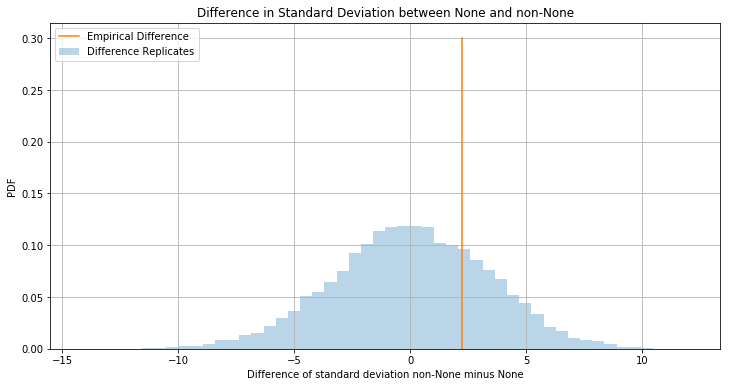

In [6]:
#adoption ratio test
adopt_diff_test('color2', 'None', 10000)

#time to adoption test
time_diff_test('color2', 'None', 10000)

### Results (Solid vs. Mixed)
* The test shows that in 10000 iterations, there was not one case found where the difference in adoption ratios was as extreme as the empirical difference in adoption ratios.
* So we can reject the null hypothesis that there is not a difference in adoption ratios between solid and mixed coat color.  The p-value is below $\alpha$. 
* Moreover, the empirical difference in ratios suggests that Mixed Color dogs are adopted more than solid color dogs.


* For the time to adoption tests it seems that the null hypothesis cannot be rejected.  The test did not yield a significant result with p-value beind > $\alpha$.
    * It seems that the time adoption distributions and expected values are very similar for solid and mixed color dogs. 


** Although, the result is significant that mixed color dogs are adopted more than solid colored dogs it is only by 2.4% empirically.  I would not devote too much time focusing on color as the key factor in adoptions.  Moreover, there are a lot more mixed color dogs than solid color.  Plus, the difference in time to adoption is not significant.  Maybe try bringing roughly 2.4% more solid color dogs to adoption events.**
*****

## 3. Does the gender of the dog have a significant impact on adoptions and time to adoption?
* I hypothesize that there isn't a difference between male and female adoptions and time to adoption.
* Since there are only 282 unknown values for gender, I will lump these in together with Females as the count of females is lower than males.
* The test significance level is  αα  = 0.05.
* The null hypothesis is that there isn't a difference in distributions of adoptions or time to adoption.

In [7]:
#checking counts of each group
dogs_join.intake_sex.value_counts()

Male       26504
Female     22771
Unknown      289
Name: intake_sex, dtype: int64

Male group data points: 26504. Non-Male group data points: 23060.
The empirical Male ratio:0.7499245396921219
The empirical non-Male ratio:0.7361231569817867
The empirical difference of ratios(non minus cat) is -0.013801382710335264.

The 95% confidence interval is -0.0075570455057726305 to 0.007688868707965035.
p-val = 0.0002


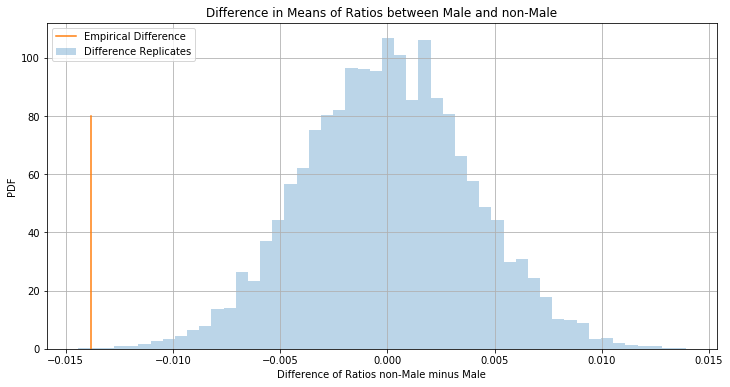

Male group data points: 19876. Non-Male group data points: 16975.
Male std:44.20615221458974
Non-Male std:48.65402667225744
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 4.4478744576676945.

The 95% confidence interval is -6.1374557152450295 to 6.210342463444397.
p-val = 0.0808


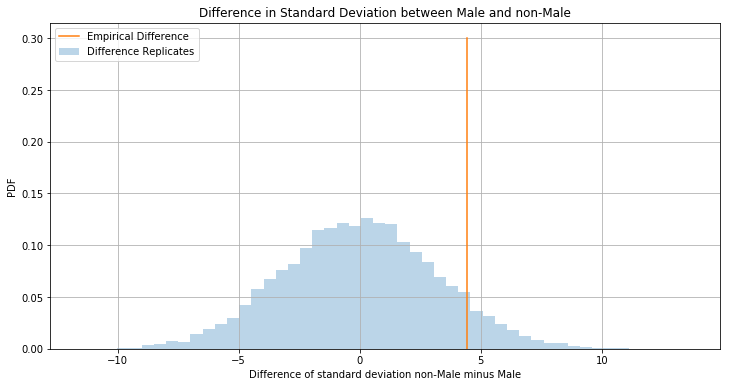

In [8]:
#adoption ratio test
adopt_diff_test('intake_sex', 'Male', 10000)

#time to adoption test
time_diff_test('intake_sex', 'Male', 10000)

### Results (Male vs. Female)
* The test shows that in 10000 iterations, there was only a few instances found where the difference in adoption ratios was as extreme as the empirical difference in adoption ratios.
* So we can reject the null hypothesis that there is not a difference in adoption ratios between male and female.  The p-value is below $\alpha$. 
* Moreover, the empirical difference in ratios suggests that Male dogs are adopted more than Female dogs.


* For the time to adoption tests it seems that the null hypothesis cannot be rejected.  The test did not yield a significant result with p-value being > $\alpha$.
    * It seems that the time adoption distributions and expected values are similar for Male and Female dogs. 
    

**The result shows that there is not a significant difference in the time to adoptions for male and females.  The significant result in percent adoptions suggests that there is 1.3% higher adoptions for males than females.  I wouldn't focus too much on the adoptability of males to females.  Simply presenting an equal ratio of males to females or slightly shifted to more females would probably be the best course of action.  Also, there are more males in the shelter historically.**
    
*****

## 4. Does breed population impact adoptions and time to adoptions?
* I hypothesize that there is a difference between populous breeds and non-populous breeds adoptions and time to adoption.
* To test this, the groups will be the top 5 primary breeds in intakes vs. the rest of the breeds.
* The test significance level is  $\alpha$  = 0.05.
* The null hypothesis is that there is not a difference in distributions of adoptions or time to adoption.

In [9]:
#need to make a column for top vs. none top 5
for index, row in dogs_join.iterrows():
    if row['breed1'] in dogs_join.breed1.value_counts()[:5].index.values:
        dogs_join.loc[index, 'population'] = 'top5'
    else:
        dogs_join.loc[index, 'population'] = 'bottom'

top5 group data points: 25074. Non-top5 group data points: 24490.
The empirical top5 ratio:0.7400893355667225
The empirical non-top5 ratio:0.7469987750102083
The empirical difference of ratios(non minus cat) is 0.006909439443485765.

The 95% confidence interval is -0.0076192502043685995 to 0.007797303810854639.
p-val = 0.0422


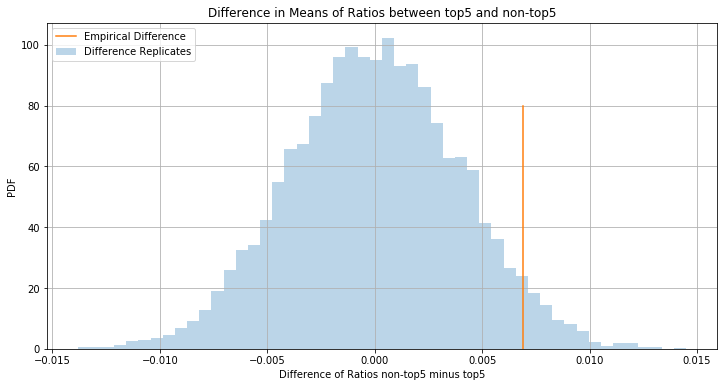

top5 group data points: 18557. Non-top5 group data points: 18294.
top5 std:51.482968455983716
Non-top5 std:40.19349171415096
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -11.289476741832758.

The 95% confidence interval is -6.269726586763514 to 6.116644771789044.
p-val = 0.0001


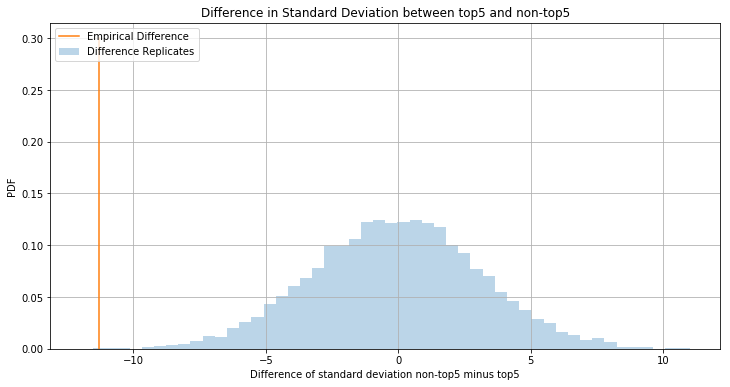

In [10]:
#adoption ratio test
adopt_diff_test('population', 'top5', 10000)

#time to adoption test
time_diff_test('population', 'top5', 10000)

### Results (Populous Breeds  vs. Non-populous Breeds)
* The test shows that in 10000 iterations, there was only a few instances found where the difference in adoption ratios was as extreme as the empirical difference in adoption ratios.
* So we can reject the null hypothesis that there is not a difference in adoption ratios between populous and non-populous breeds.  The p-value is below $\alpha$. 
* Moreover, the empirical difference in ratios suggests that Non-populous breeds are adopted at a higher ratio than populous breeds.


* For the time to adoption tests, it seems that the null hypothesis can be rejected.  The test yielded a significant result with p-value being < $\alpha$.
    * It seems that the time adoption distributions and expected values are different for Populous and Non-populous breeds.
    * Moreover, the expected value for time to adoption seems to be higher for the populous breeds.
    
** The result of this test suggests that Populous breeds in the shelter need more attention than the non-populous breeds.  It seems even in dogs being rare is desirable.  Both the adoptability and time to adoption are favored to the non-populous breeds significantly.  The rarer breeds seem to handle themselves, while more attention and effort in marketing/adoption events needs to be geared toward the more populous breeds in the shelter.  There are more of those to adopt as well, so moving them would more greatly reduce the shelter population than moving the less populous breeds.**
    
*****

## 5. Does any American Kennel Club Breed Group have better adoptability or time to adoption?
* I hypothesize that certain breed groups have a difference in distribution of adoptions and times to adoption.
* To test this, the groups will be the breeds are separated into the AKC groups and tested one vs. all for each AKC group.
* The test significance level is  $\alpha$  = 0.05.
* The null hypothesis is that there isn't a difference in distributions of adoptions or time to adoption.

In [11]:
#try to group breeds into AKC groups
AKC_breeds = {'Hound':['Afghan Hound','American English Coonhound','American Foxhound','Basenji','Basset Hound','Beagle',
                       'Black and Tan Coonhound','Bloodhound','Bluetick Coonhound','Borzoi','Cirneco Dell’Etna','Dachshund',
                       'English Foxhound','Grand Basset Griffon Vendeen','Greyhound','Harrier','Ibizan Hound','Irish Wolfhound',
                       'Norwegian Elkhound','Otterhound','Petit Basset Griffon Vendeen','Pharaoh Hound','Plott',
                       'Portuguese Podengo Pequeno','Redbone Coonhound','Rhodesian Ridgeback','Saluki','Scottish Deerhound',
                       'Sloughi','Treeing Walker Coonhound','Whippet','Rhod Ridgeback','Plott Hound','Dachshund Stan',
                       'Podengo Pequeno','Dachshund Longhair','Pbgv','English Coonhound','Bluetick Hound','Redbone Hound',
                      'Dachshund Wirehair'],
             'Herding':['Australian Cattle Dog','Australian Shepherd','Bearded Collie','Beauceron','Belgian Malinois',
                        'Belgian Sheepdog','Belgian Tervuren','Bergamasco','Berger Picard','Border Collie','Bouvier des Flandres',
                        'Briard','Canaan Dog','Cardigan Welsh Corgi','Collie','Entlebucher Moutain Dog','Finnish Lapphund',
                        'German Shepherd Dog','German Shepherd','Icelandic Sheepdog','Miniature American Shepherd','Norwegian Buhund',
                        'Old English Sheepdog','Pembroke Welsh Corgi','Polish Lowland Sheepdog','Puli','Pumi','Pyrenean Shepherd',
                        'Queensland Heeler','Shetland Sheepdog','Spanish Water Dog','Swedish Vallhund','Blue Lacy','Entlebucher',
                       'Picardy Sheepdog','Bouv Flandres','Collie Rough','Collie Smooth'],
             'Toy':['Affenpinscher','Brussels Griffon','Cavalier King Charles Spaniel','Chihuahua','Chihuahua Shorthair','Chinese Crested',
                    'English Toy Spaniel','Havanese','Italian Greyhound','Japanese Chin','Maltese','Manchester Terrier',
                    'Miniature Pinscher','Papillon','Pekingese','Pomeranian','Toy Poodle','Pug','Shih Tzu','Silky Terrier',
                    'Toy Fox Terrier','Yorkshire Terrier','Chihuahua Longhair','Bruss Griffon','Cavalier Span','Eng Toy Spaniel'],
             'Non-Sporting':['American Eskimo','American Eskimo Dog','Bichon Frise','Boston Terrier','Bulldog','Chinese Shar-Pei','Chow Chow',
                             'Coton De Tulear','Dalmatian','Finish Spitz','French Bulldog','Keeshond','Lhasa Apso','Lowchen',
                             'Norwegian Lundhund','Poodle','Schipperke','Shiba Inu','Tibetan Spaniel','Tibetan Terrier',
                             'Xoloitzcuintli','Chinese Sharpei','Miniature Poodle','American Bulldog','Finnish Spitz',
                            'English Bulldog', 'Old English Bulldog','Standard Poodle','Mexican Hairless'],
             'Sporting':['American Water Spaniel','Boykin Spaniel','Brittany','Chesapeake Bay Retriever','Clumber Spaniel',
                         'Cocker Spaniel','Curly-Coated Retriever','English Cocker Spaniel','English Setter',
                         'English Springer Spaniel','Field Spaniel','Flat-Coated Retriever','German Shorthaired Pointer',
                         'German Wirehaired Pointer','Golden Retriever','Gordon Setter','Irish Red and White Setter',
                         'Irish Setter','Irish Water Spaniel','Labrador Retriever','Lagotto Romagnolo',
                         'Nederlandse Kooikerhondje','Nova Scotia Duck Tolling Retriever','Pointer','Spinone Italiano',
                         'Sussex Spaniel','Vizsla','Weimaraner','Welsh Springer Spaniel','Wirehaired Pointing Griffon',
                         'Wirehaired Vizsla','German Shorthair Pointer','Flat Coat Retriever','Chesa Bay Retr','English Pointer',
                        'Boykin Span','Sussex Span'],
              'Terrier':['Airedale Terrier','American Hairless Terrier','American Staffordshire Terrier','Australian Terrier',
                         'Bedlington Terrier','Border Terrier','Bull Terrier','Cairn Terrier','Cesky Terrier',
                         'Dandie Dinmont Terrier','Glen of Imaal Terrier','Irish Terrier','Jack Russell Terrier',
                         'Kerry Blue Terrier','Lakeland Terrier','Manchester Terrier','Miniature Bull Terrier','Miniature Schnauzer',
                         'Norfolk Terrier','Norwich Terrier',
                         'Parson Russell Terrier','Pit Bull','Rat Terrier','Russell Terrier','Scottish Terrier','Sealyham Terrier',
                         'Skye Terrier','Smooth Fox Terrier','Soft Coated Wheaten Terrier','Staffordshire Bull Terrier',
                         'Staffordshire','Welsh Terrier','West Highland White Terrier','Wire Fox Terrier','West Highland',
                        'Wire Hair Fox Terrier','Bull Terrier Miniature','Dandie Dinmont','Bedlington Terr','Glen Of Imaal',
                        'Sealyham Terr'],
             'Working':['Akita','Alaskan Malamute','Anatolian Shepherd Dog','Bernese Mountain Dog','Black Russian Terrier',
                        'Boerboel','Boxer','Bullmastiff','Cane Corso','Catahoula','Chinook','Doberman Pinscher','Dogue de Bordeaux',
                        'German Pinscher','Giant Schnauzer','Great Dane','Great Pyrenees','Greater Swiss Mountain Dog',
                        'Komondor','Kuvasz','Leonberger','Mastiff','Neapolitan Mastiff','Newfoundland','Portuguese Water Dog',
                        'Rottweiler','Samoyed','Siberian Husky','Standard Schnauzer','Tibetan Mastiff','St. Bernard','Doberman Pinsch',
                       'St. Bernard Rough Coat','Dogue De Bordeaux','Anatol Shepherd','Port Water Dog','St. Bernard Smooth Coat',
                       'Schnauzer Giant']}

for index, row in dogs_join.iterrows():
    val = False
    for key, value in AKC_breeds.items():
        if row['breed1'] in value:
            dogs_join.loc[index,'AKC_group'] = key
            val = True
    if not val:
        dogs_join.loc[index,'AKC_group'] = 'Misc'

In [12]:
#check AKC groups
dogs_join.AKC_group.value_counts()

Terrier         11786
Toy              9437
Sporting         8394
Herding          7209
Working          4917
Hound            3711
Non-Sporting     2710
Misc             1400
Name: AKC_group, dtype: int64

Sporting group data points: 8394. Non-Sporting group data points: 41170.
The empirical Sporting ratio:0.750774362639981
The empirical non-Sporting ratio:0.7420208889968424
The empirical difference of ratios(non minus cat) is -0.00875347364313861.

The 95% confidence interval is -0.0101876960936913 to 0.009891418214046377.
p-val = 0.0455


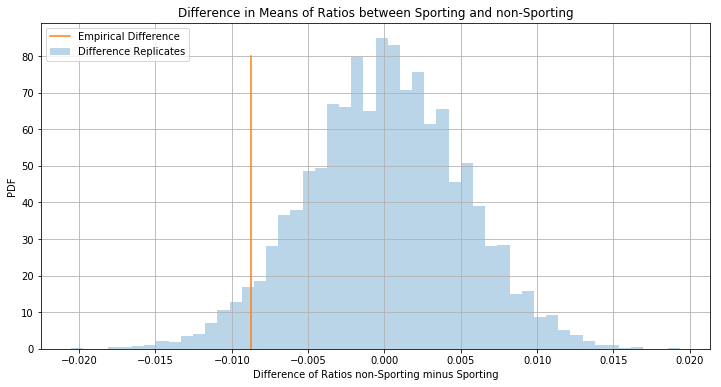

Sporting group data points: 6302. Non-Sporting group data points: 30549.
Sporting std:49.80079316327116
Non-Sporting std:45.5542091768262
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -4.246583986444961.

The 95% confidence interval is -8.289914814176534 to 7.8338243035309985.
p-val = 0.15


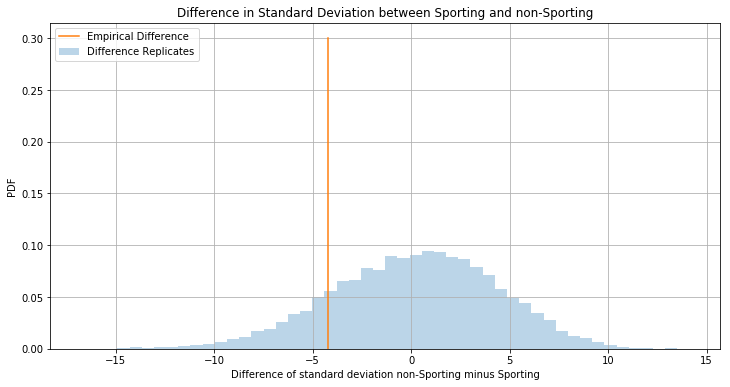

Hound group data points: 3711. Non-Hound group data points: 45853.
The empirical Hound ratio:0.7434653732147669
The empirical non-Hound ratio:0.7435064226986239
The empirical difference of ratios(non minus cat) is 4.1049483856969715e-05.

The 95% confidence interval is -0.014522848997789883 to 0.014604947965503823.
p-val = 0.4943


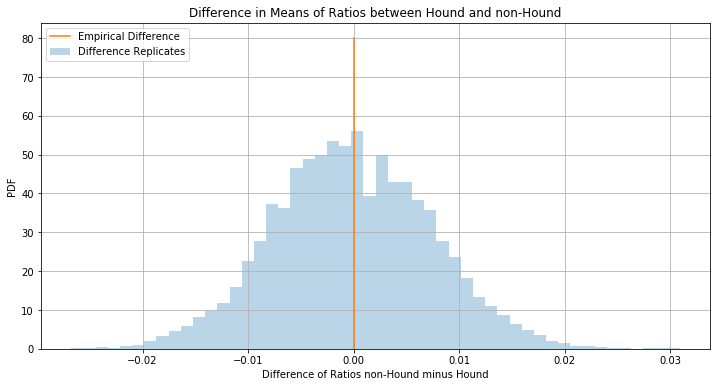

Hound group data points: 2759. Non-Hound group data points: 34092.
Hound std:30.92175286500643
Non-Hound std:47.31653858833126
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 16.394785723324834.

The 95% confidence interval is -11.897350704966232 to 10.771624049486793.
p-val = 0.0001


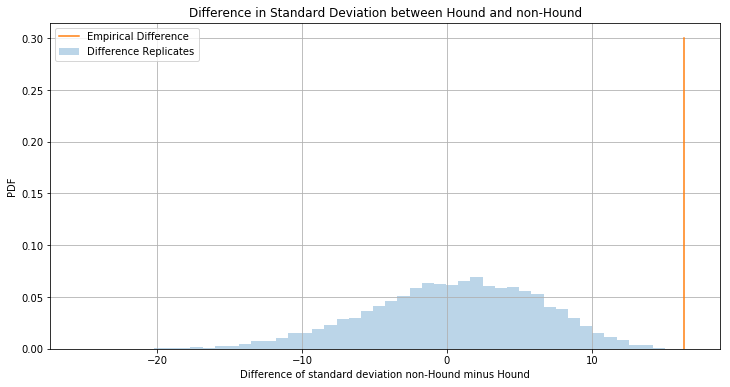

Herding group data points: 7209. Non-Herding group data points: 42355.
The empirical Herding ratio:0.77819392426134
The empirical non-Herding ratio:0.7375988667217566
The empirical difference of ratios(non minus cat) is -0.04059505753958348.

The 95% confidence interval is -0.01105182419717976 to 0.011024438080660337.
p-val = 0.0


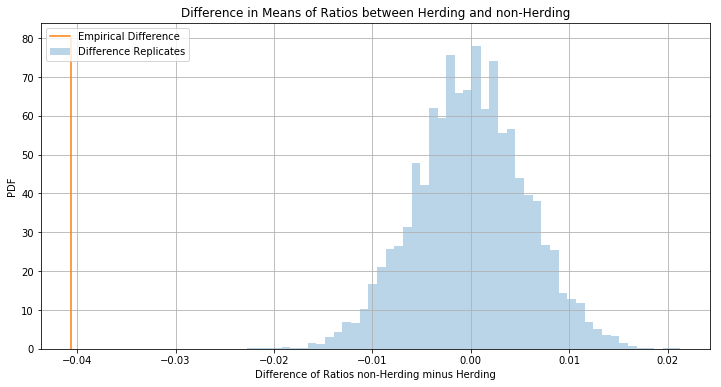

Herding group data points: 5610. Non-Herding group data points: 31241.
Herding std:36.94063286510521
Non-Herding std:47.79058939929951
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 10.849956534194305.

The 95% confidence interval is -8.967418601807948 to 8.232426656019237.
p-val = 0.0021


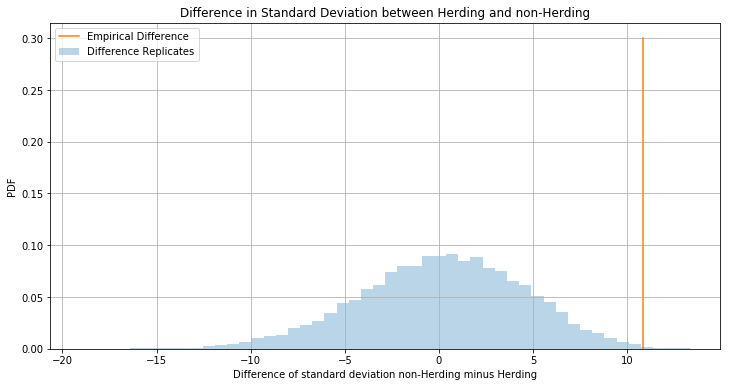

Terrier group data points: 11786. Non-Terrier group data points: 37778.
The empirical Terrier ratio:0.7385033090106906
The empirical non-Terrier ratio:0.7450632643337393
The empirical difference of ratios(non minus cat) is 0.00655995532304865.

The 95% confidence interval is -0.009135722006358704 to 0.009120243114370319.
p-val = 0.0819


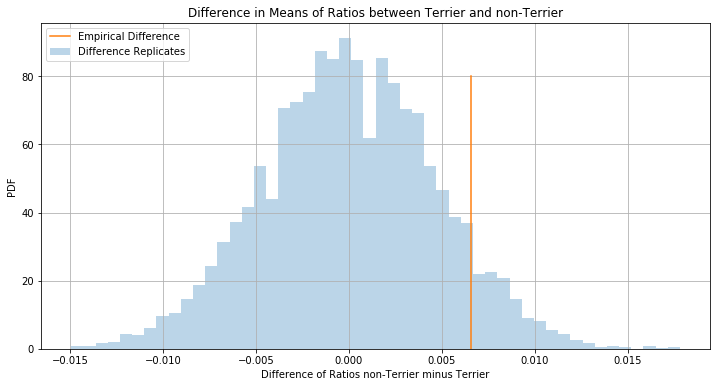

Terrier group data points: 8704. Non-Terrier group data points: 28147.
Terrier std:56.89971889121329
Non-Terrier std:42.31057878103578
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -14.58914011017751.

The 95% confidence interval is -7.336886873055833 to 7.172303296459692.
p-val = 0.0001


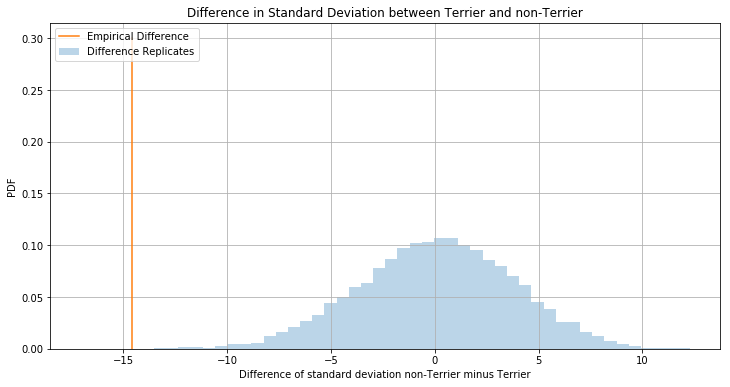

Non-Sporting group data points: 2710. Non-Non-Sporting group data points: 46854.
The empirical Non-Sporting ratio:0.7309963099630996
The empirical non-Non-Sporting ratio:0.7442267469159517
The empirical difference of ratios(non minus cat) is 0.013230436952852087.

The 95% confidence interval is -0.016826250091160233 to 0.01752424938771091.
p-val = 0.0668


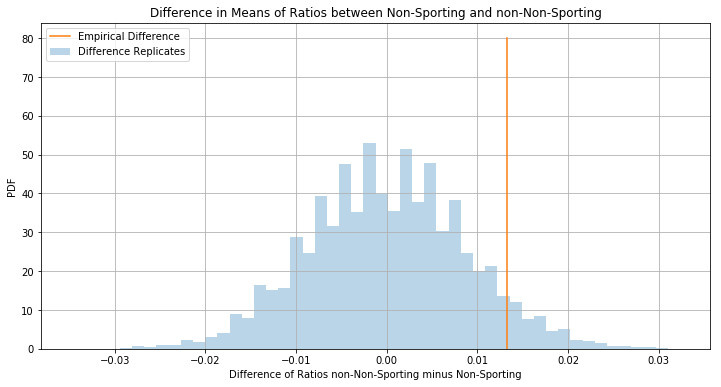

Non-Sporting group data points: 1981. Non-Non-Sporting group data points: 34870.
Non-Sporting std:41.15114559804909
Non-Non-Sporting std:46.581921554930304
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 5.430775956881213.

The 95% confidence interval is -14.5170452003568 to 11.905159855308195.
p-val = 0.2513


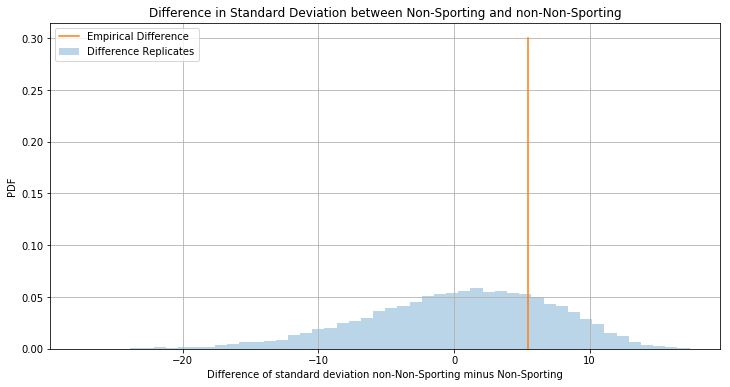

Toy group data points: 9437. Non-Toy group data points: 40127.
The empirical Toy ratio:0.7064745152061036
The empirical non-Toy ratio:0.7522117277643482
The empirical difference of ratios(non minus cat) is 0.04573721255824459.

The 95% confidence interval is -0.009758771648664455 to 0.009612468121671713.
p-val = 0.0


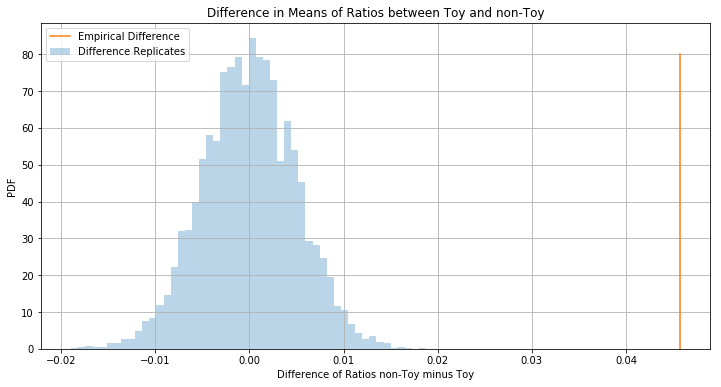

Toy group data points: 6667. Non-Toy group data points: 30184.
Toy std:30.64755467498196
Non-Toy std:49.00697595155807
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 18.359421276576107.

The 95% confidence interval is -8.33845878923351 to 7.811866857861212.
p-val = 0.0


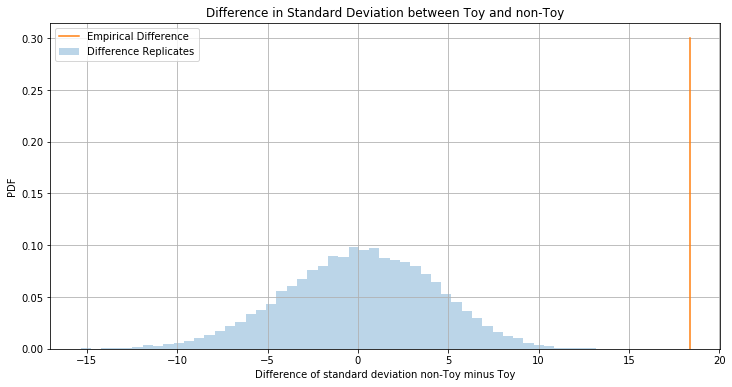

Working group data points: 4917. Non-Working group data points: 44647.
The empirical Working ratio:0.7671344315639618
The empirical non-Working ratio:0.7409008444016395
The empirical difference of ratios(non minus cat) is -0.02623358716232227.

The 95% confidence interval is -0.01268714933581594 to 0.012830952919865095.
p-val = 0.0


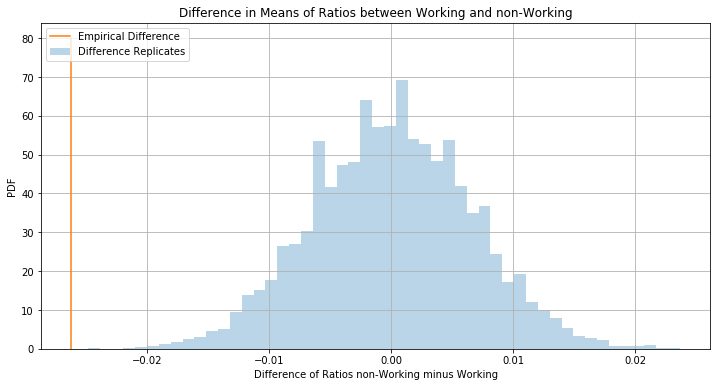

Working group data points: 3772. Non-Working group data points: 33079.
Working std:52.484558097620344
Non-Working std:45.55446447907488
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -6.930093618545463.

The 95% confidence interval is -10.289323041788698 to 9.592949536650803.
p-val = 0.0912


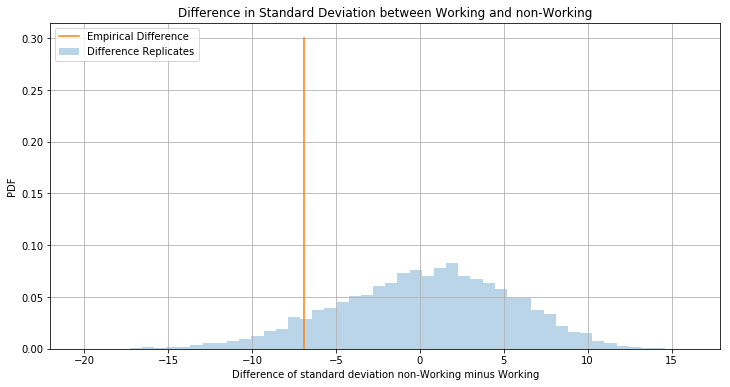

Misc group data points: 1400. Non-Misc group data points: 48164.
The empirical Misc ratio:0.7542857142857143
The empirical non-Misc ratio:0.7431899343908314
The empirical difference of ratios(non minus cat) is -0.011095779894882973.

The 95% confidence interval is -0.023591597755288518 to 0.02345148124859109.
p-val = 0.1872


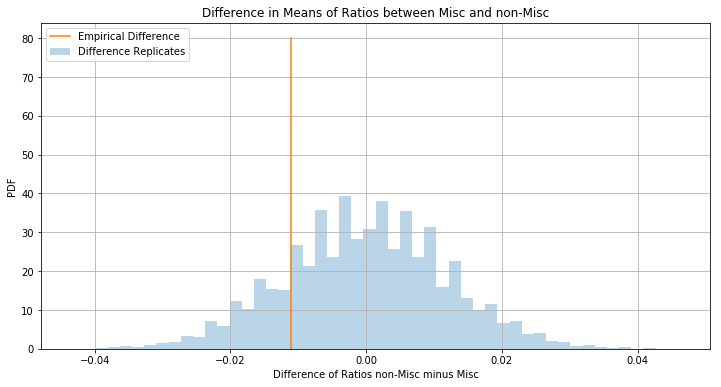

Misc group data points: 1056. Non-Misc group data points: 35795.
Misc std:62.9649631964892
Non-Misc std:45.71753079184879
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -17.247432404640413.

The 95% confidence interval is -19.614858175298917 to 14.959578519342616.
p-val = 0.04


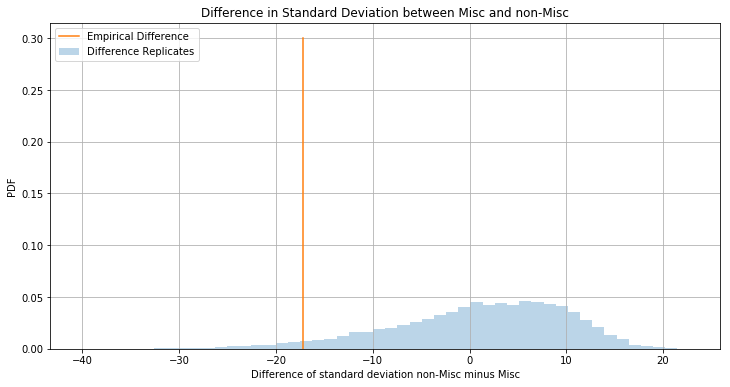

In [13]:
#Now check to see if any one group stands out from the rest statistically
for group in dogs_join.AKC_group.unique():
    adopt_diff_test('AKC_group', group, 10000)
    time_diff_test('AKC_group', group, 10000)

### Results (AKC breeds one  vs. all)
* Test Summary results:

|Group|Adoption Ratio|Time to Adoption|
|-----|--------------|----------------|
|Sporting|Not Significant|Not Significant|
|Hound|Not Significant|Significant(less)|
|Herding|Significant(more)|Significant(less)|
|Terrier|Not Significant|Significant(more)|
|Non-Sporting|Not Significant|Not Significant|
|Toy|Significant(less)|Significant(less)|
|Working|Significant(more)|Not Significant|
|Misc|Not Significant|Significant(more)|

* **The results are a mixed bag of significant results.  No one AKC group stands out among the rest.  However, some groups pop up as being potentially troublesome, the ones such as Toy with a significant Adoption Ratio value suggesting their adoption ratio is lower compared to the others.  More time should be spent in trying to get the groups with lower adoptability represented.  Also, more educational events could be done to educate potential pet owners on the difference between the groups and breeds.  This could lead to a reduction in return visits as the pet owner would adopt on a educated basis as to what type of dog suits their lifestyle better perhaps.** 


* **Also, Misc and Terrier groups seem to take longer to adopt than the other groups.  More attention should be paid in getting these dogs adopted.**
    
*****

## 6. Is there a correlation between time to adoption and intake age?
* I hypothesize that there is a correlation between time to adoption and intake age.
* To test this, all the dogs who have outcome_type of adoption will be organized by intake age and correlated with time to adoption.
* The test significance level is  $\alpha$  = 0.05.
* The null hypothesis is that there is not a correlation.


* Test setup:
    * To simulate the null hypothesis, we need to:
        * Calculate the empirical correlation coefficient.
        * Permute one of the variables and keep one steady.
        * Then, calculate the correlation coefficient(test statistic).
        * Repeat this many times until a distribution of correlation coefficients are generated.
        * The p-value will be the count of instances where the permuted correlation coefficient is at least as extreme as the empirical correlation coefficient.

In [14]:
#define the correlation test function
def corr_test(data1, data2, label1, label2, size=1):
    """Runs a permutation test for correlation and generates a p-value, 95% confidence interval, and a histogram."""
    
    #print labels for the particular correlation test
    print("Test for correlation between {} and {}.".format(label1, label2))
    
    #calculate the empirical correlation
    emp_corr = np.corrcoef(data1, data2)[0][1]
    

    print("The empirical correlation coefficient is {}.".format(round(emp_corr,3)))
    print("")

    # Initialize permutation replicates: perm_replicates
    perm_replicates = np.empty(size)

    # Draw replicates
    for i in range(size):
        # Permute data1 measurments
        data1_permuted = np.random.permutation(data1)

        # Compute Pearson correlation
        perm_replicates[i] = np.corrcoef(data1_permuted,data2)[0][1]

    # Compute p-value: p
    if emp_corr < 0:
        p = np.sum(perm_replicates <= emp_corr)/len(perm_replicates)
    else:
        p = np.sum(perm_replicates >= emp_corr)/len(perm_replicates)
        
    print("The 95% confidence interval is {} to {}."
          .format(np.percentile(perm_replicates,2.5),np.percentile(perm_replicates,97.5)))
    print('p-val =', p)

    #make a histogram of the replicate correlations and show where the empirical result lies
    plt.figure(figsize=(12,6))
    pd.Series(perm_replicates).hist(alpha=0.3, normed=True, bins=50)
    plt.plot([emp_corr,emp_corr], [0,80])
    plt.xlabel('Pearson Correlation Coefficient')
    plt.ylabel('PDF')
    plt.legend(['Empirical Correlation','Correlation Replicates'], loc='upper left')
    plt.title('Empirical Correlation Coefficient Distribution')
    plt.show()

Test for correlation between Intake Age and Time to Adoption.
The empirical correlation coefficient is 0.032.

The 95% confidence interval is -0.01016265036568587 to 0.010811798480104344.
p-val = 0.0


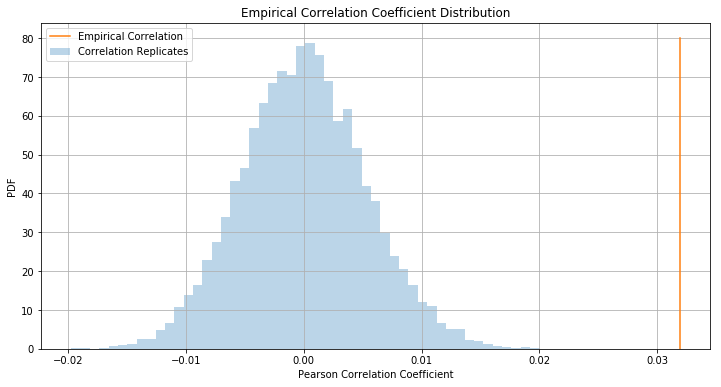

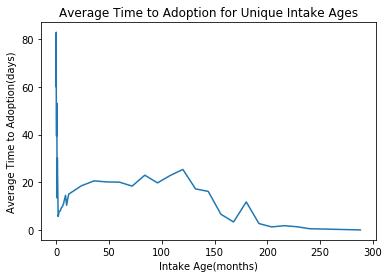

In [15]:
#run the correlation test
corr_test(dogs_adoptions.intake_age.values,dogs_adoptions.shelter_time.values,'Intake Age','Time to Adoption',10000)

#average shelter time for each unique age in intake age
avg_shelter_time = [np.mean(dogs_adoptions.shelter_time[dogs_adoptions.intake_age == age]) 
                    for age in dogs_adoptions.intake_age.sort_values().unique()]

#plot shelter time vs intake age
plt.plot(dogs_adoptions.intake_age.sort_values().unique(),avg_shelter_time)
plt.xlabel('Intake Age(months)')
plt.ylabel('Average Time to Adoption(days)')
plt.title('Average Time to Adoption for Unique Intake Ages')
plt.show()

### Results (Correlation between Intake Age and Time to Adoption)
* The test shows that in 10000 iterations, there were no instances found where the correlation coefficient was as extreme as the empirical correlation coefficient.
* So we can reject the null hypothesis that there is not a correlation between intake age and time to adoption.  The p-value is below $\alpha$. 
* Moreover, the empirical correlation suggests that there is a slight positive correlation between intake age and time to adoption.  However, this correlation is quite small at 0.03.
    * **This suggests that the older the dog is upon intake, the longer it will take to get adopted.  This could be a trouble area to look out for in the shelter as well, focusing more time and attention promoting older dogs vs puppies as the puppy vs non puppy test suggested as well.**
    * **However, looking at the scatterplot it seems the youngest dogs have the longest times to adoptions, but this time could include weening and spay/neuter time.  Next, it seems that the time to adoption increases almost logarithmically with age until about 50 months of age.  Then, it seems like the really old dogs have shorter times to adoptions, but this is based on fewer samples.**

*****

## 7. Are adoptions affected by seasons?
* I hypothesize that certain seasons have differences in distribution of adoptions and times to adoption.
* To test this, the groups will be the seasons, and they will be tested one vs. all for each season.
* The test significance level is  $\alpha$  = 0.05.
* The null hypothesis is that there is not a difference in distributions of adoptions or time to adoption.

Spring group data points: 13147. Non-Spring group data points: 36417.
The empirical Spring ratio:0.7546968890241119
The empirical non-Spring ratio:0.7394623390174918
The empirical difference of ratios(non minus cat) is -0.015234550006620107.

The 95% confidence interval is -0.008712620975504848 to 0.008782712457169772.
p-val = 0.0002


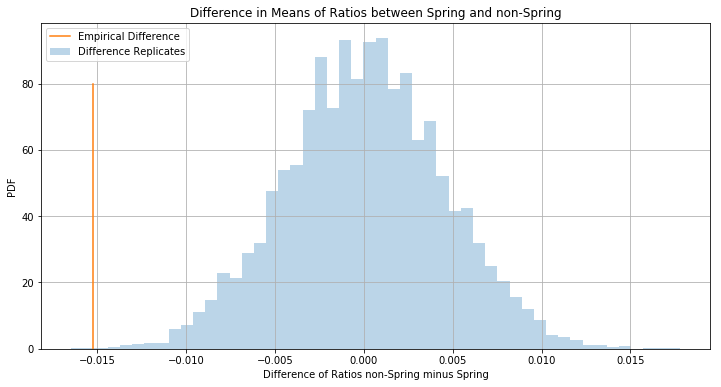

Spring group data points: 9922. Non-Spring group data points: 26929.
Spring std:41.74427214835676
Non-Spring std:47.884393955385946
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 6.140121807029189.

The 95% confidence interval is -7.063495387388331 to 6.875413407254724.
p-val = 0.0437


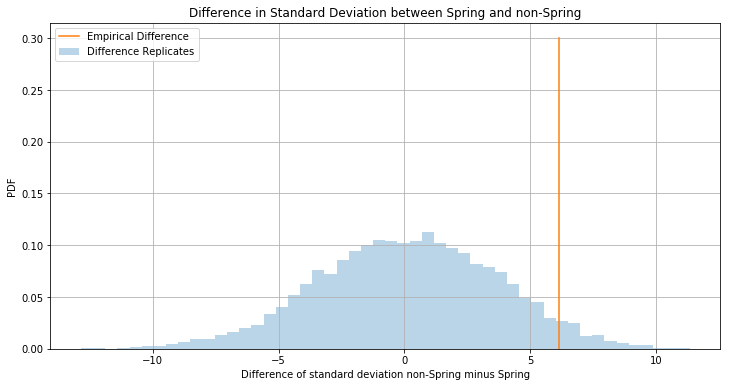

Winter group data points: 12344. Non-Winter group data points: 37220.
The empirical Winter ratio:0.7670123136746597
The empirical non-Winter ratio:0.7357066093498119
The empirical difference of ratios(non minus cat) is -0.031305704324847805.

The 95% confidence interval is -0.008974897641425894 to 0.008827717686746697.
p-val = 0.0


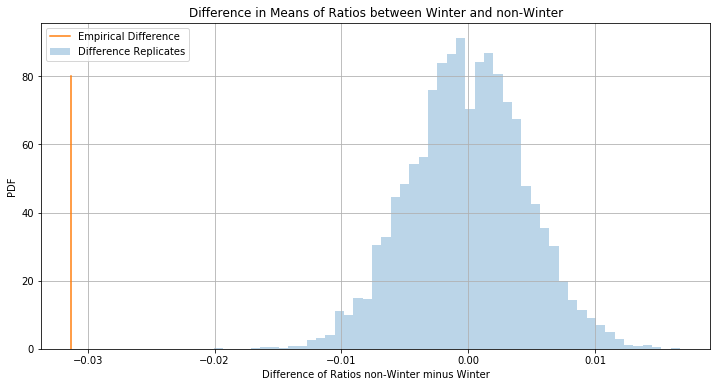

Winter group data points: 9468. Non-Winter group data points: 27383.
Winter std:46.642541545575895
Non-Winter std:46.19622772385271
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -0.44631382172318723.

The 95% confidence interval is -7.320062496036219 to 7.056976057034326.
p-val = 0.4352


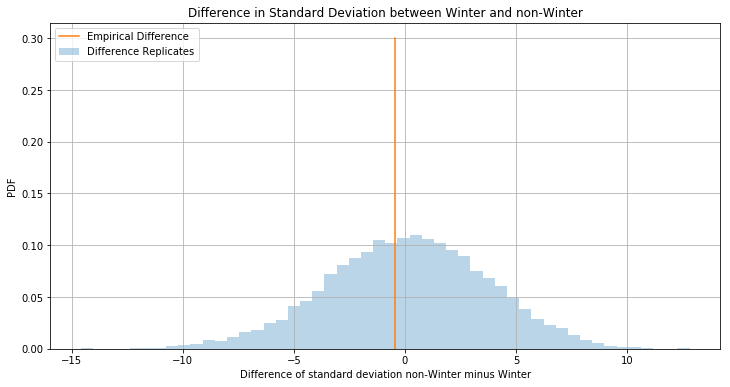

Fall group data points: 11752. Non-Fall group data points: 37812.
The empirical Fall ratio:0.7245575221238938
The empirical non-Fall ratio:0.7493917274939172
The empirical difference of ratios(non minus cat) is 0.024834205370023454.

The 95% confidence interval is -0.008961969204959841 to 0.009107272647011389.
p-val = 0.0


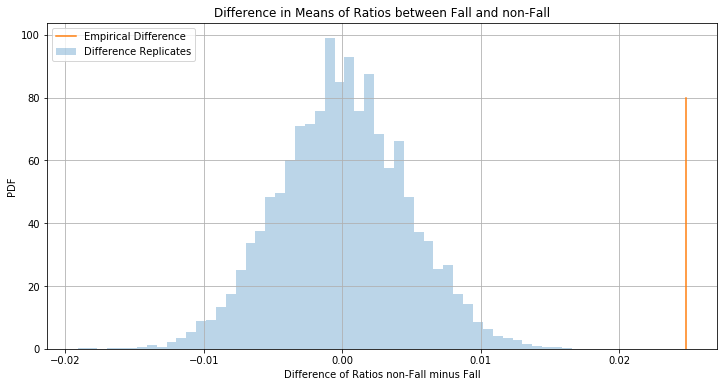

Fall group data points: 8515. Non-Fall group data points: 28336.
Fall std:53.725972429370216
Non-Fall std:43.830444563487475
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -9.895527865882741.

The 95% confidence interval is -7.483832724244525 to 7.306804719381779.
p-val = 0.0053


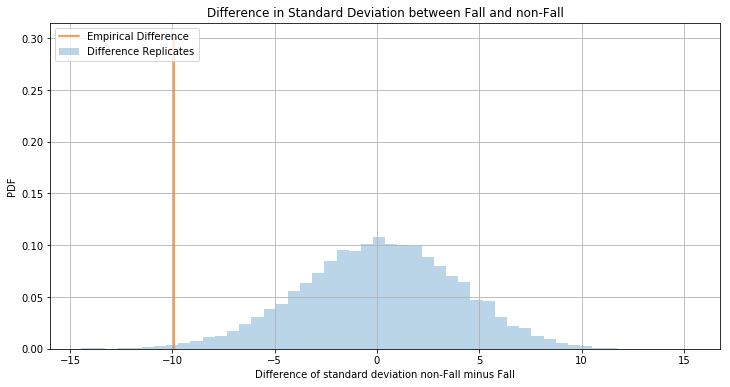

Summer group data points: 12321. Non-Summer group data points: 37243.
The empirical Summer ratio:0.7260774287801315
The empirical non-Summer ratio:0.7492683188787155
The empirical difference of ratios(non minus cat) is 0.023190890098583994.

The 95% confidence interval is -0.008672923270333532 to 0.009041196704251075.
p-val = 0.0


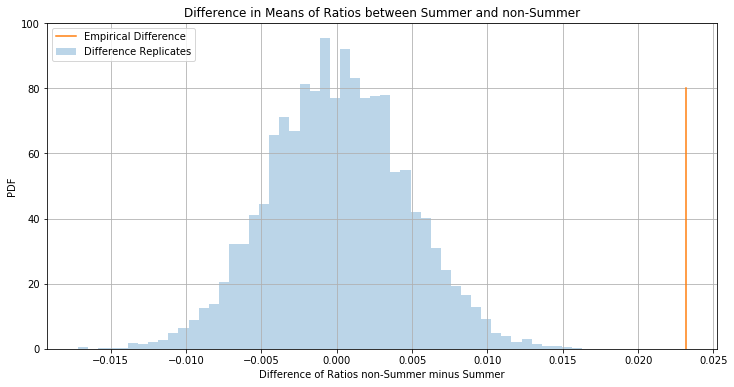

Summer group data points: 8946. Non-Summer group data points: 27905.
Summer std:43.00653910826353
Non-Summer std:47.31891559529706
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 4.312376487033525.

The 95% confidence interval is -7.424341372605339 to 7.152961372589157.
p-val = 0.1319


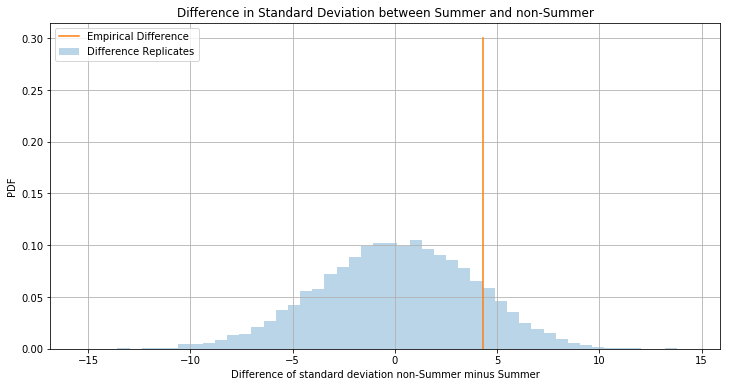

In [16]:
#Now check to see if any one group stands out from the rest statistically
for group in dogs_join.intake_season.unique():
    adopt_diff_test('intake_season', group, 10000)
    time_diff_test('intake_season', group, 10000)

### Results (Seasons one  vs. all)
* Test Summary results:

|Season|Adoption Ratio|Time to Adoption|
|-----|--------------|----------------|
|Spring|Significant(More)|Significant(less)|
|Winter|Significant(More)|Not Significant|
|Fall|Significant(less)|Significant(more)|
|Summer|Significant(less)|Not Significant|

* The results are all significant results for the adoptability tests.  This means that we can reject the null hypothesis that the distribution of adoption ratios is not different.  The test results suggest that Summer and Fall may be times with less adoptability and that Spring and Winter have higher adoptability.
    * **More time, effort, adoption events could be spent in the summer and fall to even out the adoptability of dogs throughout the year.**


* For time to adoption, the results are mixed significance.  However, spring seems to have lower times to adoption(expected value) as compared to the other seasons.  Moreover, Fall seems to have higher times to adoption(expected value) as compared to the other seasons.
    * **Once again, more can be done in the months with higher time to adoption to aid in increasing the efficiency at which the dogs are adopted throughout the year.**

*****

## That will conclude the statistical testing.  Now onto machine learning and prediction.